# Assignment 1

Explain

## Olympics
--
Todo

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv("E:/gitrepos/olympics/data/athlete_events.csv")

## Business Understanding
---
Todo

In [9]:
1+1

2

## Data Meaning Type
---
Todo

In [10]:
1+1

2

## Data Quality
---
Todo

In [11]:
1+1

2

## Simple Statistics
---
Todo

In [12]:
1+1

2

## Visualize Attributes
---
Todo

In [13]:
1+1

2

## Explore Joint Attributes
---
Todo

## Explore Attributes and Class
---
Podium finishers -- finishing in top 3 of an event -- are going to be predicted using cross-validation against the test and train data sets. Accuracy will determine how well the prediction algorithm is performing.

Before building a prediction model, we will compare the response variable "podium finish" to other columns in the data set and explore the relationships. We will explore age, height, and weight and their relationship to podium finishes and medal type.

We first explore medal distribution across age, height, and weight with a pairplot. In this visualization, we see a uniform medal type distribution for age and small variations for height and weight. 

In [21]:
##sns.pairplot(df, vars=['Age', 'Height', 'Weight'], hue='Medal', height=2.5)

Next, we will look at age and the podium finishes for different age groups.

Text(0.5,1,'Age vs Podium Finishes')

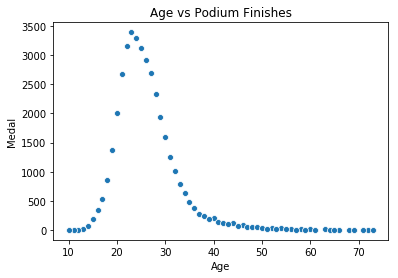

In [23]:
age_info = df[df['Medal'].notna()].groupby(['Age'])['Medal'].count().sort_values(ascending=False)
age_df = pd.DataFrame({'Age': age_info.index, 'Medal': age_info.values })
sns.scatterplot(x="Age", y="Medal", data=age_df)
plt.title("Age vs Podium Finishes")

Text(0.5,1,'Podium Finishes By Age Group')

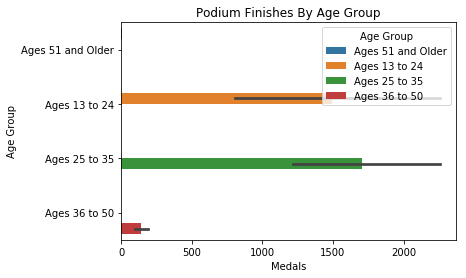

In [16]:
medal_count_by_age = df[(df['Medal'] != 'NA')].groupby(['Age'])['Medal'].count()

amd = pd.DataFrame({'Age': np.trunc(medal_count_by_age.index),
                                  'Medals': medal_count_by_age.values})

def form_age_group(age):
    if age >= 13 and age <= 24:
        return 'Ages 13 to 24'
    elif age >= 25 and age <= 35:
        return 'Ages 25 to 35'
    elif age >= 36 and age <= 50:
        return 'Ages 36 to 50'
    else:
        return 'Ages 51 and Older'
    
amd['Age Group'] = amd['Age'].apply(form_age_group)

sns.barplot(x="Medals", y="Age Group", hue="Age Group", data=amd, orient='h')
plt.title('Podium Finishes By Age Group')

Clearly the vast majority of podium finishers are between the ages of 13 and 35, so we will dig deeper to explore the relationship.

Text(0.5,1,'Podium Finishes By Age Group')

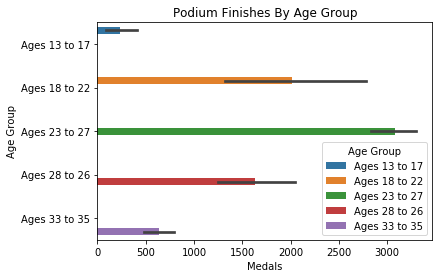

In [22]:
def form_age_group2(age):
    if age >= 13 and age <= 17:
        return 'Ages 13 to 17'
    elif age >= 18 and age <= 22:
        return 'Ages 18 to 22'
    elif age >= 23 and age <= 27:
        return 'Ages 23 to 27'
    elif age >= 28 and age <= 32:
        return 'Ages 28 to 26'
    elif age >= 33 and age <= 35:
        return 'Ages 33 to 35'
    
amd['Age Group'] = amd['Age'].apply(form_age_group2)

sns.barplot(x="Medals", y="Age Group", hue="Age Group", data=amd, orient='h')
plt.title('Podium Finishes By Age Group')

As expected podium finishes are normally distributed among the age groups.

Next we will perform a similar analysis with weight.

Text(0.5,1,'Weight vs Podium Finish')

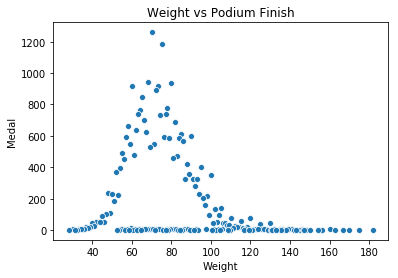

In [36]:
weight_info = df[df['Medal'].notna()].groupby(['Weight'])['Medal'].count().sort_values(ascending=False)
weight_df = pd.DataFrame({'Weight': weight_info.index, 'Medal': weight_info.values })
sns.scatterplot(x="Weight", y="Medal", data=weight_df)
plt.title("Weight vs Podium Finish")

In [ ]:
weight_df.describe()

## New Features
---
The data set is somewhat limited in features, so feature engineering or bringing in additional features from outside of this particular data set could be beneficial. For example, individual-specific data is limited to age, sex, weight, and height. Bringing in additional performance indicators could potentially help predict podium finishes or help with trend analysis:<br>
-Olympic best<br>
-Personal best<br>
-Body Fat %<br>
-Repeat Olympian<br>
-Previous Podium<br><br>
Bringing in additional country of origin indicators could potentially be helpful as well:<br>
-GDP per capita<br>
-Population

## Exceptional Work
---
Todo

In [ ]:
1+1